### **Эксперимент 5.**

Рассчитать приведенную температуру (через egt, tat, ... theta) и n1. Отбросить `egt, tat, n1, XF, HPV, NF`.

Использовать конфигурацию эксперимента 4. 

Сохранить и записать использованные константы.

Note: выяснилось, что если убрать NF то качество сильно падает. разобраться, почему

Note: 'p2e' добавляет точности

In [39]:
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

bgu.loc[bgu['oat'].isna(), ['oat']] = bgu.loc[bgu['oat'].isna(), :]['tat']
bdu.loc[bdu['oat'].isna(), ['oat']] = bdu.loc[bdu['oat'].isna(), :]['tat']

In [40]:
bgu.head(3)

,reportts,acnum,pos,egtm,fltdes,dep,arr,ivs12,ibe,iaie,...,votm,vsva,w14,pf,wai,nai,prv,hpv,xf,reason
0,2018-12-24 10:53:22,VQ-BGU,1,44.437,8990.0,EDHI,UUDD,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
1,2018-12-25 15:23:23,VQ-BGU,1,44.379,1024.0,URSS,UUDD,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
2,2018-12-25 20:49:27,VQ-BGU,1,43.742,217.0,UUDD,UNBB,NaN,NaN,NaN,...,NaN,0.0,1302.0,0.51,0.0,0.0,1.0,0.0,0.0,NaN


#### Подготовка

In [41]:
import pandas as pd
from utils import *
from training import *

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'oat' 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']

data = build_dataset(
  [bgu, bdu], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

1.0001104543519546


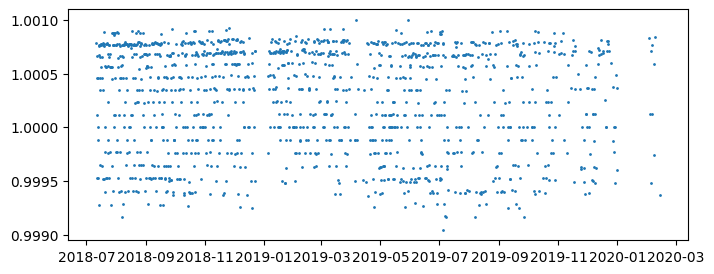

In [42]:
import matplotlib.pyplot as plt

print((data['nf'] / data['n1a']).mean())

plt.figure(figsize=(8, 3))
sub = data[(data['pos'] == 2) & (data['acnum'] == 'VQ-BDU')]
plt.scatter(sub['reportts'], sub['n1a'] / sub['nf'], s=1)
plt.show()

In [44]:
from sklearn.linear_model import LinearRegression

def train_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = LinearRegression()
  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

#### Baseline из эксперимента 4

In [45]:
X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

In [46]:
base_metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'Baseline: {base_metrics}')


Baseline: {'rmse': 1.56302, 'mae': 1.28427, 'r2': 0.56243, 'mape': 0.06234}


#### Коррекция

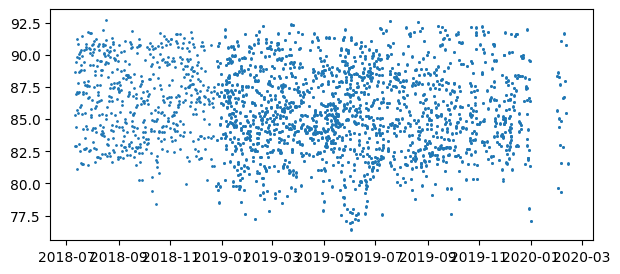

In [47]:
theta = (data['tat'] + 273.15) / 288.15
alpha = 0.5

data['n1k'] = data['n1a'] / (theta ** alpha)
plt.figure(figsize=(7, 3))
plt.scatter(data['reportts'], data['n1k'], s=1)
plt.show()

In [48]:
bdu['oat'].isna().sum()

0

In [49]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  theta = (data['tat'] + 273.15) / 288.15
  theta_oat = (data['oat'] + 273.15) / 288.15
  delta = data['p2e'] + 1013.25

  datak['nfk'] = data['nf'] / (theta_oat ** alpha)
  datak['n1ak'] = data['n1a'] / (theta_oat ** alpha)
  datak['n1k'] = data['n1'] / (theta_oat ** alpha)
  datak['n2ak'] = data['n2a'] / (theta_oat ** alpha)
  datak['egtk'] = (data['egt'] + 273.15) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta_oat ** alpha))

  return datak


In [50]:
features = ['egtk', 'tat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nf']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'EGT + FF corrections: {metrics}')


EGT + FF corrections: {'rmse': 1.58261, 'mae': 1.30171, 'r2': 0.55139, 'mape': 0.06291}


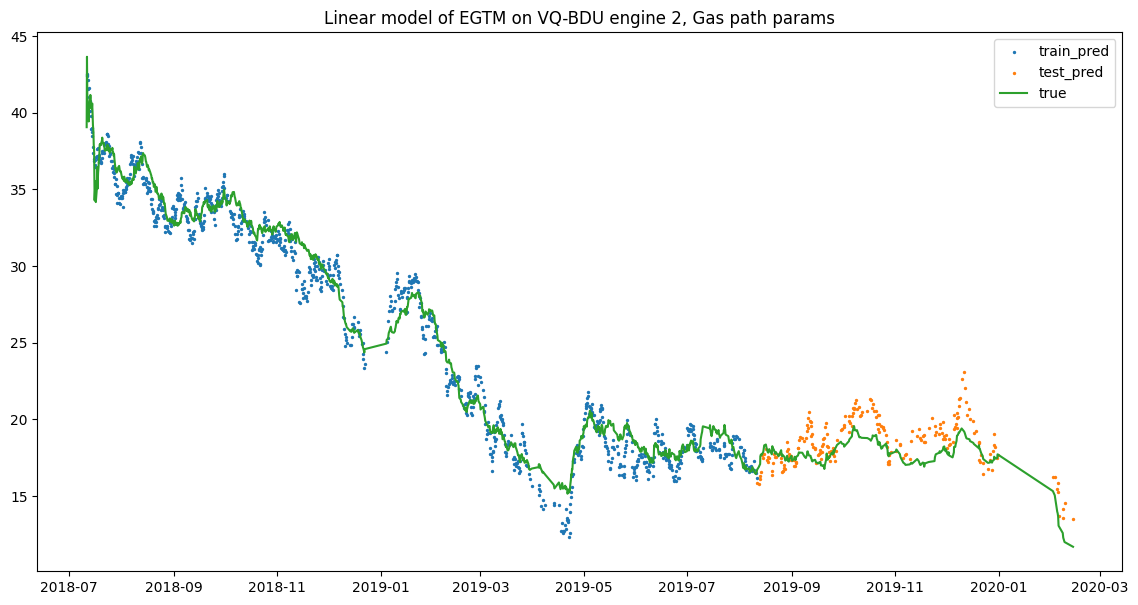

In [51]:
plot_predictions(data, 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=False)

Wow, just the egt + fuel flow correction gained us 0.1 increase in R squared!

N1, N2, NF corrections give worse results fow unknown reason

Comparison of corrections: 

In [52]:
features = ['egt', 'n1a', 'n2a', 'ff', 'nf', 'tat', 'wai', 'nai', 'prv', 'alt', 'mn']

corrected = [correct(bgu), correct(bdu)]

base_metrics['name'] = 'baseline'
history = [base_metrics]

for param in ['egt', 'n1a', 'n2a', 'ff']:
  cur_features = [f'{param}k' if i == param else i for i in features]

  data = build_dataset(
    corrected,
    y_cols, 
    meta_cols, 
    cur_features,
    n_back=13,
  )

  X = data.drop(columns=(meta_cols + y_cols))
  y = data['egtm']

  metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

  metrics['name'] = param.upper()
  history.append(metrics)

pd.DataFrame(history)

,rmse,mae,r2,mape,name
0,1.56302,1.28427,0.56243,0.06234,baseline
1,1.60954,1.32359,0.53600,0.06398,EGT
2,2.74855,2.23881,-0.35308,0.10794,N1A
3,2.27237,1.85298,0.07514,0.08993,N2A
4,1.70490,1.40107,0.47939,0.06797,FF


In [70]:
features = ['egtk', 'oat', 'tat', 'n1ak', 'n2ak', 'prv', 'mn', 'nfk']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=13,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

print(f'Baseline: {metrics}')

Baseline: {'rmse': 1.49408, 'mae': 1.22532, 'r2': 0.60018, 'mape': 0.05928}


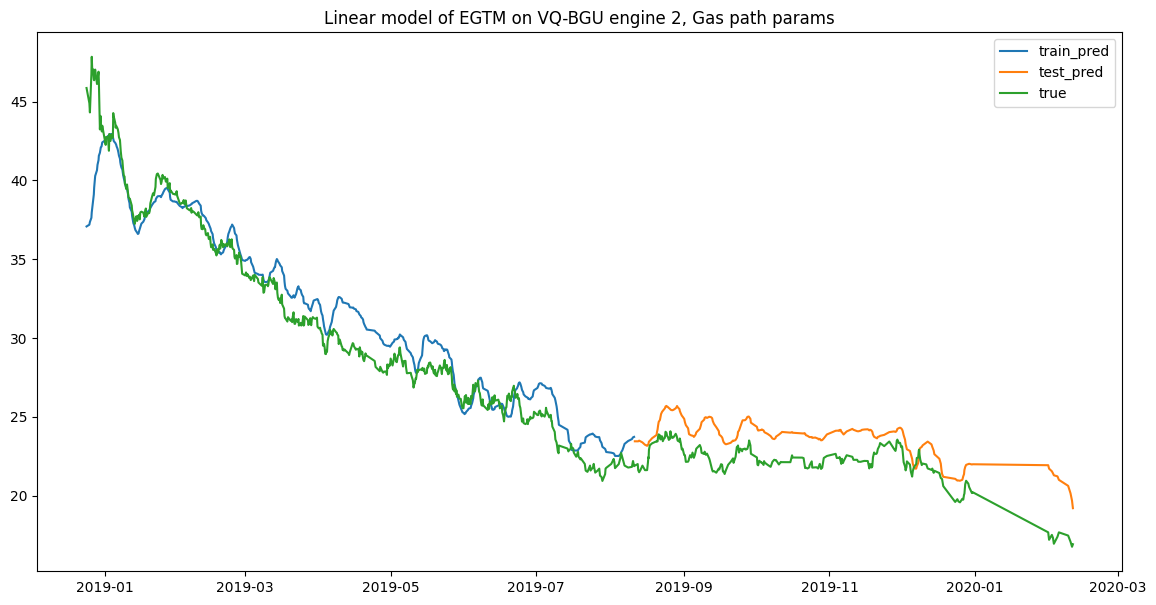

In [79]:
plot_predictions(data, 'VQ-BDU', 1, train_i, predicted_test, predicted_train, is_smooth=False)